# MiniGPT For Generating Synthetic Text Data

by Kris Smith

# ***WARNING*** 

## The data required to train the model for this task is known to be vulgar, offensive, toxic, racist, and otherwise not pleasant.

## Problem Statement

Toxic comments online come in many forms and in many arenas. There are currently several ways to mitigate these comments(for those organizations who wish to do so). Some of these ways include human moderators, and training machine learning models to detect toxicity in online comments.

The issue with human moderators is that some of these platforms have grown so large so quickly that there are not nearly enough moderators to achieve any sense of control for most of these comments. The shear volume of toxicity and bots online makes it unrealistic to think we could do this job with humans at this point.

Many companies are employing machine learning to assist with identifying toxic comments online automatically. The problem with this approach is the lack of labeled training data to train the models on.

This is the problem I am going to solve using generative deep learning techniques. 

## References

* [Improving Language Understanding by Generative Pre-Training](https://www.semanticscholar.org/paper/Improving-Language-Understanding-by-Generative-Radford-Narasimhan/cd18800a0fe0b668a1cc19f2ec95b5003d0a5035)

* [Language Models are Unsupervised Multitask Learners](https://www.semanticscholar.org/paper/Language-Models-are-Unsupervised-Multitask-Learners-Radford-Wu/9405cc0d6169988371b2755e573cc28650d14dfe)

* [Language Models are Few-Shot Learners](https://arxiv.org/abs/2005.14165)

* Many of the ideas and code were adapted from this Keras resource: https://keras.io/examples/generative/text_generation_with_miniature_gpt/

## Import Libraries

In [25]:
import os
import string
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk import ngrams
from collections import Counter
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Data

The data I will be using to train the generative model was released on Kaggle as part of an ongoing series of competitions sponsored by the [Google company Jigsaw](https://en.wikipedia.org/wiki/Jigsaw_(company)).

The data consists of online comments with various severity levels of toxicity. There are versions of these comments labeled by human annotators wherein they label each comment as toxic or not, or other sets where they were labeled as different categories of toxic such as hatespeech, racist/sexist, obscene, etc. Although these are the labeled datasets we would be adding the synthetic data to in order to create more training data, for this task of simply generating similar text data we will only focus on the comments themselves.

The data provided by this competition includes a total of `14,251` unique toxic comments. Theses are the comments I will use to train the generative model with.

## EDA

The data came in two different files.

1) Comments to score: This acts as a test dataset of comments for scoring after the model was trained.

2) Validation data: This was the training data for the competition wherein there are two columns. One column labeled less toxic was a comment which human annotators labeled as less toxic than its more toxic counterpart in the other column. There was no actual training data where a comment was paired with its severity rating. The models were trained using creative techniques with the validation data and other classification data sets to train a model which predicted severity of comments.

Since for our purposes we are only interested in the actual text comments themselves, I will only be using those columns from these datasources.

I start by reading them all into pandas dataframes, isolating the text columns from each one, and stacking them all together so we have a single column of text when it is all said and done.


In [26]:
data1 = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv')
data1.info()

## Isolate only text column
data1 = data1['text']

data1.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7537 entries, 0 to 7536
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   comment_id  7537 non-null   int64 
 1   text        7537 non-null   object
dtypes: int64(1), object(1)
memory usage: 117.9+ KB


3265    "HEY VACUOS, EMPTY- MINDED COLA! GET A LIFE! T...
7293    Because it is an R&B; album, and Wikipedia's c...
921     Dakota is a baby and so is angel they are not ...
6319     I am coming to get you \n\ni know where you l...
5356    Justafax, you are an angry individual and you ...
827     A big thank you\n\nYou have just blocked me in...
Name: text, dtype: object

We can see the comments to score was the test file which contained only comments and their corresponding id's

In [27]:
data2 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data2.info()

data2.sample(6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30108 entries, 0 to 30107
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   worker      30108 non-null  int64 
 1   less_toxic  30108 non-null  object
 2   more_toxic  30108 non-null  object
dtypes: int64(1), object(2)
memory usage: 705.8+ KB


,worker,less_toxic,more_toxic
19819,209,Stop deleting my edits! They are useful so I w...,Sign your fucking comments! 80.192.32.85
5933,244,"""\n\nWell done yourself, Shot. Nothing like a ...","I have done nothing wrong, so I dont care. I a..."
16050,382,Beware websites that HAVE NO AUTHOR NAME. Wh...,You're ridiculous if you jump to conclusions l...
28702,604,"Jenny Craig==\n\nYeah, homie. I don't know if ...",I'll bet 80% of what she did was rubbish...
27888,654,bad motherfuckers \n\nThere are a lot of them...,I agree with Carribean about the unsourced and...
28263,465,"Stupid \n\nyou are not a macedonian, you have...","Gwen Gale's Pimp \n\nI know you are her pimp,..."


This was the data provided to validate the models performance during training. The three columns are workers(annotators) and the other two are text columns which we will use both to train our generative model with.

#### Combine all columns into a single column

In [28]:
## Isolate text column
data2 = data2['more_toxic']

## Isolate text column
data3 = pd.read_csv('../input/jigsaw-toxic-severity-rating/validation_data.csv')
data3 = data3['less_toxic']

text_column = pd.concat([data1, data2, data3], axis=0, ignore_index=True)

#### Check for duplicates

In [29]:
text_column.value_counts()

 sorry i jumped to conclusions \n\non christian terrorism article man, I don't agree with you, and I want you to go and listen to 'prophet of doom' (now in audio format) as it is good. But I was wrong to be so rude. It is not the Southern European way.                                                                                                                                                                               19
this irishtom guy is turning every article into an ad for islam                                                                                                                                                                                                                                                                                                                                                                            19
You are not sorry one damned bit.  You have yet to refute what I have written.  All you do is pass the insults as if it were salt on the din

It looks like between the data provided for the competition there are many duplicates. However we can see that some comments are reused many more times than other comments. For example the most used comments were repeated `19` times in the datasets while others only `2` times. 

Since the duplications are not balanced if we left the data like this I am afraid we would be biasing the model towards the comments which were present more in the data. 

I will remove all duplicate comments.

In [30]:
print(f"Total numer of comments in text data = {len(text_column)}")
print(f"Numer of unique comments in text data = {len(text_column.unique())}")

text_column = text_column.drop_duplicates()
print("Duplicate comments dropped")

Total numer of comments in text data = 67753
Numer of unique comments in text data = 14251
Duplicate comments dropped


### Exploring the toxic comments

In [31]:
data = pd.DataFrame()
data['text'] = text_column
data = data.sample(100)

# Function to calculate word count
def count_words(text):
    words = nltk.word_tokenize(text)
    return len(words)

# Function to calculate verb count
def count_verbs(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    verb_count = len([word for word, tag in tagged_words if tag.startswith('V')])
    return verb_count

# Function to calculate noun count
def count_nouns(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)
    noun_count = len([word for word, tag in tagged_words if tag.startswith('N')])
    return noun_count

# Add word count column
data['word_count'] = data['text'].apply(count_words)

# Add verb count column
data['verb_count'] = data['text'].apply(count_verbs)

# Add noun count column
data['noun_count'] = data['text'].apply(count_nouns)

data.describe()

,word_count,verb_count,noun_count
count,100.000000,100.000000,100.000000
mean,104.740000,16.120000,31.550000
std,175.901179,31.514717,109.997096
min,5.000000,0.000000,1.000000
25%,22.000000,3.000000,5.000000
50%,38.500000,7.000000,10.000000
75%,99.000000,16.000000,21.000000
max,1111.000000,278.000000,1064.000000


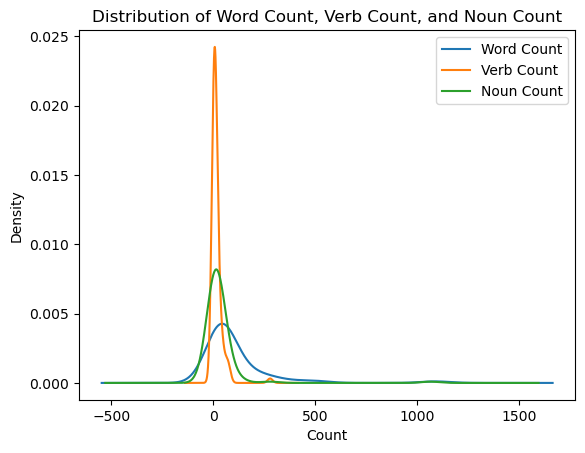

In [32]:
ax = data['word_count'].plot(kind='kde')
data['verb_count'].plot(kind='kde', ax=ax)
data['noun_count'].plot(kind='kde', ax=ax)

ax.legend(['Word Count', 'Verb Count', 'Noun Count'])
ax.set_title('Distribution of Word Count, Verb Count, and Noun Count')
ax.set_xlabel('Count')
ax.set_ylabel('Density')

plt.show()

We can see that these comments on average are quite short in length and contain more nouns than verbs on average.

Since we have not done any cleaning of the data yet these distributions are not exact as the nltk package is not currently looking for misspelled words or different versions of word spellings which are used online sometimes.

For example if a user knows that the platform they are on has limitations on language than they may spell a profane word to try to fool any auto detecting systems such as `Fuck==>Fxck, F*ck, Fukk, Fuuu*uukk`, etc.

Therefore these counts will not detect all nouns and verbs but should give a decent sample.

Knowing the underlying distributions of some of these features is important because after the synthetic data is generated we would most likely want it to follow the same distributions for these attributes of the text. 

### Looking at the most common N-grams

In [33]:
# Tokenize the text into words
data['words'] = data['text'].apply(nltk.word_tokenize)

# Get bigrams and trigrams for each row
data['bigrams']   = data['words'].apply(lambda x: list(ngrams(x, 2)))
data['trigrams']  = data['words'].apply(lambda x: list(ngrams(x, 3)))
# data['quadgrams'] = data['words'].apply(lambda x: list(ngrams(x, 4)))

# Count the occurrences of bigrams and trigrams
bigram_counts   = Counter([gram for grams in data['bigrams'] for gram in grams])
trigram_counts  = Counter([gram for grams in data['trigrams'] for gram in grams])
# quadgram_counts = Counter([gram for grams in data['quadgrams'] for gram in grams])

# Get the most common bigrams, trigrams, and quadgrams
most_common_bigrams   = bigram_counts.most_common(50)
most_common_trigrams  = trigram_counts.most_common(50)
# most_common_quadgrams = quadgram_counts.most_common(50)

df_common_grams = pd.DataFrame()
df_common_grams['bigrams']   = most_common_bigrams
df_common_grams['trigrams']  = most_common_trigrams
# df_common_grams['quadgrams'] = most_common_quadgrams

# # Display the results
# print('Most common bigrams:')
# for bigram, count in most_common_bigrams:
#     print(' '.join(bigram), count)

# print('\nMost common trigrams:')
# for trigram, count in most_common_trigrams:
#     print(' '.join(trigram), count)
    
# print('\nMost common quadgrams:')
# for quadgram, count in most_common_quadgrams:
#     print(' '.join(quadgram), count)


df_common_grams.iloc[:, :]

,bigrams,trigrams
0,"((YOU, SUCK), 471)","((YOU, SUCK, YOU), 360)"
1,"((SUCK, YOU), 360)","((SUCK, YOU, SUCK), 360)"
2,"((BunkSteve, is), 278)","((BunkSteve, is, gay), 277)"
3,"((is, gay), 277)","((is, gay, !), 277)"
4,"((gay, !), 277)","((gay, !, BunkSteve), 277)"
5,"((!, BunkSteve), 277)","((!, BunkSteve, is), 277)"
6,"((SUCK, DICK), 111)","((YOU, SUCK, DICK), 111)"
7,"((DICK, YOU), 110)","((SUCK, DICK, YOU), 110)"
8,"(('', ''), 89)","((DICK, YOU, SUCK), 110)"
9,"((``, ''), 78)","((!, !, !), 56)"


We can see the initial 10 or so most common bi-grams and tri-grams are repetitive punctuation marks.

Traditionally these would be cleaned and removed when training models for NLP tasks, however due to the nature of this work many of these traditional techniques will limit the models ability to predict toxicity as well as with clean text.

I happened to have competed in this competition and one thing all of us learned was that leaving capital letters and punctuation improved the models ability to infer toxicity and especially levels of toxicity. 

For example a phrase such as:

`Are you kidding?`

Conveys a much different meaning than the same words but put this way:

`ARE YOU KIDDING!!!??`

Traditional NLP techniques would have us convert all characters to lower case and remove punctuation so the model will interpret both of those texts the exact same way.

When training sentiment based models or models where feeling and emotion is being conveyed in some way such as toxicity of comments, it is more than just the raw content of the words alone which gives the meaning. The puncuation and capitalizations are very expressive forms of language and as such for these problems do better left in the data.

## Pre-Processing

* First we need load in our text column as tensorflow formatted dataset

* Next we shuffle the data to avoid any patterns which may have been present

* We then slice the data into batches for processing

* Vectorize the text which will be used to create a corpus of vocabulary used when training and act as vector representations of our text

* Create the corpus of vocabulary which is used to train and evaluate throughout

In [34]:
vocab_size = 20000  ## Only consider the top 20k words
maxlen = 80  ## Max sequence length
batch_size = 32  ## Data loading batch sizes

# Create a dataset from the pandas column
text_ds = tf.data.Dataset.from_tensor_slices(text_column)

# Shuffle and batch the dataset
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


## Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=None,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  ## To get words back from token indices

## Generate Labels

Since we are building a generative auto-regressive model, we must train it to predict the next word by looking backwards and using the previous tokens to predict the highest probability for the next token.

This is fairly easy to create labels for because we simply shuffle the `TRUE` data be one token and then when training the model compares the predicted text with the next indexed word.

We can inspect what these samples and labels look like below:

In [35]:
## Function to create target column
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

In [36]:
## Select samples from the training data set to inspect
sample = text_ds.take(5) 

## Display some samples
for x, y in sample:
    # Convert token indices back to words
    input_words  = [vocab[i] for i in x[0].numpy()]
    target_words = [vocab[i] for i in y[0].numpy()]

    print("\n\n\n\nInput Sequence:")
    print(" ".join(input_words))
    print("\nTarget Sequence:")
    print(" ".join(target_words))





Input Sequence:
Damn, fellas, Paul [UNK] came to the NBA after John [UNK] retired from it! [UNK] 7 Jan 2005 (UTC)                                                             

Target Sequence:
fellas, Paul [UNK] came to the NBA after John [UNK] retired from it! [UNK] 7 Jan 2005 (UTC)                                                              




Input Sequence:
Oh shit! I better flee for the [UNK] By the way, I didn't cause any disruption. D. J. [UNK] blew this way out of proportion.                                                       

Target Sequence:
shit! I better flee for the [UNK] By the way, I didn't cause any disruption. D. J. [UNK] blew this way out of proportion.                                                        




Input Sequence:
[UNK] -) at least this is one thing I'm glad about. I'm suggesting that we keep the [UNK] [UNK] it probably won't be back. I'm still having a [UNK] check out [UNK] Niggers Association of America for details. I just [UNK] at [UNK] Fir

* ***We can see that the target or label sequence is merely our ground truth text sequence we have just shifted by `1` token. This is what our model will use to evaluate during training.***

* ***Cell below was for loading in and preprocessing the IMBD movie quotes dataset. This is the dataset I tested this approach on first.***

In [5]:
# !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

# batch_size = 128

# # The dataset contains each review in a separate text file
# # The text files are present in four different folders
# # Create a list all files
# filenames = []
# directories = [
#     "aclImdb/train/pos",
#     "aclImdb/train/neg",
#     "aclImdb/test/pos",
#     "aclImdb/test/neg",
# ]
# for dir in directories:
#     for f in os.listdir(dir):
#         filenames.append(os.path.join(dir, f))

# print(f"{len(filenames)} files")

# # Create a dataset from text files
# random.shuffle(filenames)
# text_ds = tf.data.TextLineDataset(filenames)
# text_ds = text_ds.shuffle(buffer_size=256)
# text_ds = text_ds.batch(batch_size)

# def custom_standardization(input_string):
#     """ Remove html line-break tags and handle punctuation """
#     lowercased = tf.strings.lower(input_string)
#     stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
#     return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# # Create a vectorization layer and adapt it to the text
# vectorize_layer = TextVectorization(
#     standardize=custom_standardization,
#     max_tokens=vocab_size - 1,
#     output_mode="int",
#     output_sequence_length=maxlen + 1,
# )
# vectorize_layer.adapt(text_ds)
# vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

# ## Functoin to create target column
# def prepare_lm_inputs_labels(text):
#     """
#     Shift word sequences by 1 position so that the target for position (i) is
#     word at position (i+1). The model will use all words up till position (i)
#     to predict the next word.
#     """
#     text = tf.expand_dims(text, -1)
#     tokenized_sentences = vectorize_layer(text)
#     x = tokenized_sentences[:, :-1]
#     y = tokenized_sentences[:, 1:]
#     return x, y


# text_ds = text_ds.map(prepare_lm_inputs_labels)
# text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  9419k      0  0:00:08  0:00:08 --:--:-- 17.8M


## Implement a Transformer block as a layer

In [2]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Implement an embedding layer

Create two separate embedding layers: one for tokens and one for token index (positions).

In [3]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Implement the miniature GPT model

In [4]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 80  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer


def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

## Prepare the data for word-level language modelling

Download the IMDB dataset and combine training and validation sets for a text generation task.

14251

## Implement a Keras callback for generating text

In [10]:
# class TextGenerator(keras.callbacks.Callback):
#     """A callback to generate text from a trained model.
#     1. Feed some starting prompt to the model
#     2. Predict probabilities for the next token
#     3. Sample the next token and add it to the next input

#     Arguments:
#         max_tokens: Integer, the number of tokens to be generated after prompt.
#         start_tokens: List of integers, the token indices for the starting prompt.
#         index_to_word: List of strings, obtained from the TextVectorization layer.
#         top_k: Integer, sample from the `top_k` token predictions.
#         print_every: Integer, print after this many epochs.
#     """

#     def __init__(
#         self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
#     ):
#         self.max_tokens = max_tokens
#         self.start_tokens = start_tokens
#         self.index_to_word = index_to_word
#         self.print_every = print_every
#         self.k = top_k

#     def sample_from(self, logits):
#         logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
#         indices = np.asarray(indices).astype("int32")
#         preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
#         preds = np.asarray(preds).astype("float32")
#         return np.random.choice(indices, p=preds)

#     def detokenize(self, number):
#         return self.index_to_word[number]

#     def on_epoch_end(self, epoch, logs=None):
#         start_tokens = [_ for _ in self.start_tokens]
#         if (epoch + 1) % self.print_every != 0:
#             return
#         num_tokens_generated = 0
#         tokens_generated = []
#         while num_tokens_generated <= self.max_tokens:
#             pad_len = maxlen - len(start_tokens)
#             sample_index = len(start_tokens) - 1
#             if pad_len < 0:
#                 x = start_tokens[:maxlen]
#                 sample_index = maxlen - 1
#             elif pad_len > 0:
#                 x = start_tokens + [0] * pad_len
#             else:
#                 x = start_tokens
#             x = np.array([x])
#             y, _ = self.model.predict(x)
#             sample_token = self.sample_from(y[0][sample_index])
#             tokens_generated.append(sample_token)
#             start_tokens.append(sample_token)
#             num_tokens_generated = len(tokens_generated)
#         txt = " ".join(
#             [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
#         )
#         print(f"generated text:\n{txt}\n")
        
        

# # Tokenize starting prompt
# word_to_index = {}
# for index, word in enumerate(vocab):
#     word_to_index[word] = index


In [11]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(
        self, max_tokens, start_tokens, index_to_word, top_k=10, print_every=1
    ):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_every != 0:
            return
        print(f"Epoch {epoch+1}: loss = {logs['loss']:.4f}")
        start_tokens = [_ for _ in self.start_tokens]
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"Generated text:\n{txt}\n")

In [13]:
# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

In [14]:
start_prompt = "this movie is"
start_prompt = "what is the"


start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]
num_tokens_generated = 75
text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

## Train the model

In [59]:
# from tqdm import tqdm

# # Create a wrapper function for the training loop
# def train_with_progress_bar(model, dataset, epochs, callbacks):
#     # Disable the progress bar by setting `disable=True`
#     with tqdm(total=epochs, disable=True) as pbar:
#         for epoch in range(epochs):
#             # Perform one epoch of training
#             model.fit(dataset, verbose=0, epochs=epochs, callbacks=[text_gen_callback])
            
#             # Update the progress bar manually
#             pbar.set_postfix({'Epoch': epoch + 1})
#             pbar.update(1)

# # Train the model using the wrapper function
# train_with_progress_bar(model, text_ds, N_EPOCHS, callbacks=[text_gen_callback])

Epoch 1: loss = 0.3659
1/1 [==============================] - 0s 22ms/step
Generated text:
what is the difference ? i was doing to the same thing . you have a [UNK] ? if i was gonna check the facts before you remove them .              

Epoch 2: loss = 0.3651
1/1 [==============================] - 0s 19ms/step
Generated text:
what is the fuck up . [UNK] ? fuck you , just go to a message those who lack of military newspaper is [UNK] - i have a crime . maybe an actual photos of the page . - ] . - i should

Epoch 3: loss = 0.3562
1/1 [==============================] - 0s 21ms/step
Generated text:
what is the problem ? i 'm sure that you 're a person and the idiot . . . . i 'm a [UNK] asshole . .you deserve it               

Epoch 4: loss = 0.3487
1/1 [==============================] - 0s 20ms/step
Generated text:
what is the 3rr ? just on it is clear the way i am not only attacking you today .                        

Epoch 5: loss = 0.3417
1/1 [==============================] - 0s 19ms

KeyboardInterrupt: 

In [60]:
model = create_model()

N_EPOCHS = 25
verbose = 2 ## Set to a number such as 2 to see each steps progress bar
history = model.fit(text_ds, verbose=0, epochs=N_EPOCHS, callbacks=[text_gen_callback])

Epoch 1: loss = 3.0473
1/1 [==============================] - 0s 22ms/step
Generated text:
what is the hell ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !

Epoch 2: loss = 2.2580
1/1 [==============================] - 0s 20ms/step
Generated text:
what is the problem with the problem is this joke on earth . it was not an edit warring , untwirl , i have already been a history of my talk • user page " " " , and " " [UNK] " "



KeyboardInterrupt: 

Now we can generate text continuuing from a new prmopt 

In [ ]:
new_start_prompt = "start something"
new_start_tokens = [word_to_index.get(word, 1) for word in new_start_prompt.split()]

text_gen_callback.start_tokens = new_start_tokens
text_gen_callback.on_epoch_end(0)